# Temporal statistical moments of WW3 CFSR SWH and WSP daily data from Jaunary 1st, 1993 to December 31st, 2015 

Plot figure within jupyter notebook

In [1]:
%matplotlib inline

Use the sys library in order to tell the notebook to look for files within the followinf directory path: 

In [2]:
import sys
sys.path.append('/zdata/home/lcolosi/python_functions/')

Import all libraries and functions

In [3]:
#libraries
import numpy as np #contains the major of functions used for matrix arrays  
import matplotlib.pyplot as plt # matplotlib contains functions for graphics and plot manipulation
from netCDF4 import Dataset, num2date # netCDF4 handles netCDF files
import datetime
#plotting libraries
import cmocean.cm as cmo
from matplotlib import cm 
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib import ticker
import matplotlib
from numpy import pi


#my functions
from statistical_moments_temporal import stat_moments_temporal
import cartopy_fig_module as cart

Set dimensions for data of space and time which depends on the spatial orientation of the data set and the time period which the data is collected from. For the Ifremer data set, we want the following data orientation: 

In [4]:
nt, nlon, nlat = 8400, 720, 265
initial_year = 1993
final_year = 2015
initial_mon = 1
final_mon = 12

Set filename and look at key variables and attributes

In [5]:
filename_hs = '/zdata/downloads/colosi_data_bk/binned_data/WW3/CFSR/lc_binned_data/ww3_hs_daily_binned_data_93_16.nc'
filename_wnd = '/zdata/downloads/colosi_data_bk/binned_data/WW3/CFSR/lc_binned_data/ww3_wnd_daily_binned_data_93_16.nc'

#set nc variable in order to read attributes and obtained data: 
nc_hs = Dataset(filename_hs, 'r')
nc_wnd = Dataset(filename_wnd, 'r')


#print key variables:
print(nc_hs.variables.keys())
print(nc_wnd.variables.keys())

#longitude
for at in nc_hs.variables['lon'].ncattrs():
    print("%s : %s" %(at, nc_hs.variables['lon'].getncattr(at)))

#laitude
for at in nc_hs.variables['lat'].ncattrs():
    print("%s : %s" %(at, nc_hs.variables['lat'].getncattr(at)))
    
#time 
for at in nc_hs.variables['time'].ncattrs():
    print("%s : %s" %(at, nc_hs.variables['time'].getncattr(at)))
    

odict_keys(['time', 'lon', 'lat', 'swh'])
odict_keys(['time', 'lon', 'lat', 'wsp'])
units : degrees east
units : degrees north
units : days since 1990-01-01 00:00:00
calendar : julian


Call Hs and WSP data from WW3 netcdf files 

In [6]:
hs = nc_hs.variables['swh'][:]
wsp = nc_wnd.variables['wsp'][:]
lat = nc_hs.variables['lat'][:]
lon = nc_hs.variables['lon'][:]
time = num2date(nc_hs.variables['time'][:], nc_hs.variables['time'].units)
print(lat.shape,lon.shape)

(265,) (720,)


Call data only from January 1st, 1993 to December 31st, 2015 

In [7]:
#find initial and final indices: 
#create year vector: 
years = np.array([y.year for y in time])

#creat boolean arrays and combine them: 
ind_time = years != 2016

#use the compress function to find all indices that do not lie in 1992 or 2016 and extract slices of matrix along the time axis from swh
swh_c = np.compress(ind_time, hs, axis = 0)
wsp_c = np.compress(ind_time, wsp, axis = 0)
print(swh_c.shape,wsp_c.shape)

#extract the time steps: 
time_c = time[ind_time]

(8400, 265, 720) (8400, 265, 720)


Deresolve each of the wsp 3D array such that the resolution of the figure matches that of Ifremer data

In [8]:
#import running mean library:
from running_mean import running_mean 

#reset nlon and nlat to i degree resolution: 
nlon_c = 360
nlat_c = 133

#initialize 3D array: 
swh_array_dr = np.ma.masked_all([nt, nlat_c, nlon_c])
wsp_array_dr = np.ma.masked_all([nt, nlat_c, nlon_c])

#loop through each of the matrices in the 3D array in order to deresolve each matrix one at a time:
for itime in range(0,nt,1):
    
    #call data from the 3D array 
    swh_array_d = swh_c[itime,:,:]
    wsp_array_d = wsp_c[itime,:,:]
    #preform the deresolution via convolution
    swh_dr = running_mean(data = swh_array_d, k_dim = [2, 2], task = 'deresolve', fill_val = 'mask')
    wsp_dr = running_mean(data = wsp_array_d, k_dim = [2, 2], task = 'deresolve', fill_val = 'mask')
    #Save running mean wsp into 3D array: 
    swh_array_dr[itime,:,:] = swh_dr
    wsp_array_dr[itime,:,:] = wsp_dr
    
#deresolve lon and lat: 
lat_c = running_mean(data = lat, k_dim = [2,1], task = 'deresolve', fill_val = 'none')
lon_c = running_mean(data = lon, k_dim = [2,1], task = 'deresolve', fill_val = 'none')

#fix lat_c
lat_c[132] = 66.25

print(wsp_array_dr.shape, np.ma.is_masked(wsp_array_dr))

(8400, 133, 360) True


Compute statistical moments of the data seasonally

In [9]:
swh_stats_s = stat_moments_temporal(data=swh_array_dr, date_time=time_c, task='seasonally')
wsp_stats_s = stat_moments_temporal(data=wsp_array_dr, date_time=time_c, task='seasonally')

Assign key variables from dictionary as variables and convert variables to numpy arrays

In [10]:
#For SWH:
swh_mean_s = np.ma.array(swh_stats_s['mean'])
swh_var_s = np.ma.array(swh_stats_s['var'])
swh_skew_s = np.ma.array(swh_stats_s['skew'])
swh_kurt_s = np.ma.array(swh_stats_s['kurt'])

#For WSP:
wsp_mean_s = np.ma.array(wsp_stats_s['mean'])
wsp_var_s = np.ma.array(wsp_stats_s['var'])
wsp_skew_s = np.ma.array(wsp_stats_s['skew'])
wsp_kurt_s = np.ma.array(wsp_stats_s['kurt'])

Reinitialize longitude and latitude

In [11]:
lon_c = np.arange(0,360,1)
lat_c = np.arange(-66,67,1)

Plot the seasonal progression for each statistical moment using cartopy 

#### SWH

###### Mean

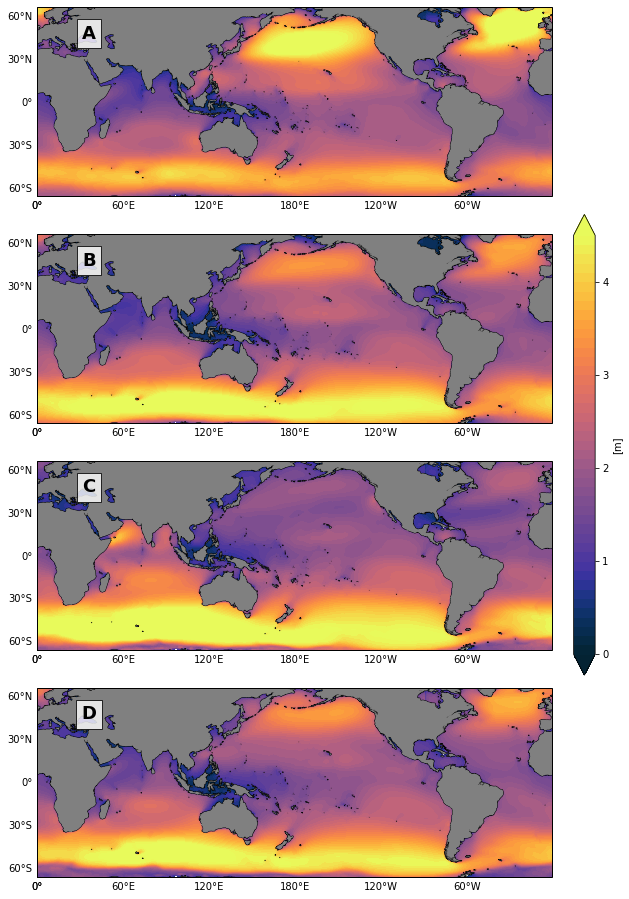

In [12]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 1, figsize=(10,16),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 4.6, 0.1)
cs1 = ax1.contourf(lon_c, lat_c, swh_mean_s[0,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.90, .3, 0.03, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.86, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 4.6, 0.1)
cs2 = ax2.contourf(lon_c, lat_c, swh_mean_s[1,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax2 = plt.axes([.92, .71, 0.01, 0.16])
#cart.set_cbar(cs2, cax2, fig, cbar_label ='[m^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.86, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 4.6, 0.1)
cs3 = ax3.contourf(lon_c, lat_c, swh_mean_s[2,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.86, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 4.6, 0.1)
cs4 = ax4.contourf(lon_c, lat_c, swh_mean_s[3,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.86, subplot_label = 'D', fs_shade = 28, fs_main = 18)


#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0.2)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/stat_moments/WW3/CFSR/WW3_seasonal_mean_swh', bbox_inches = 'tight', dpi=300)

###### Variance

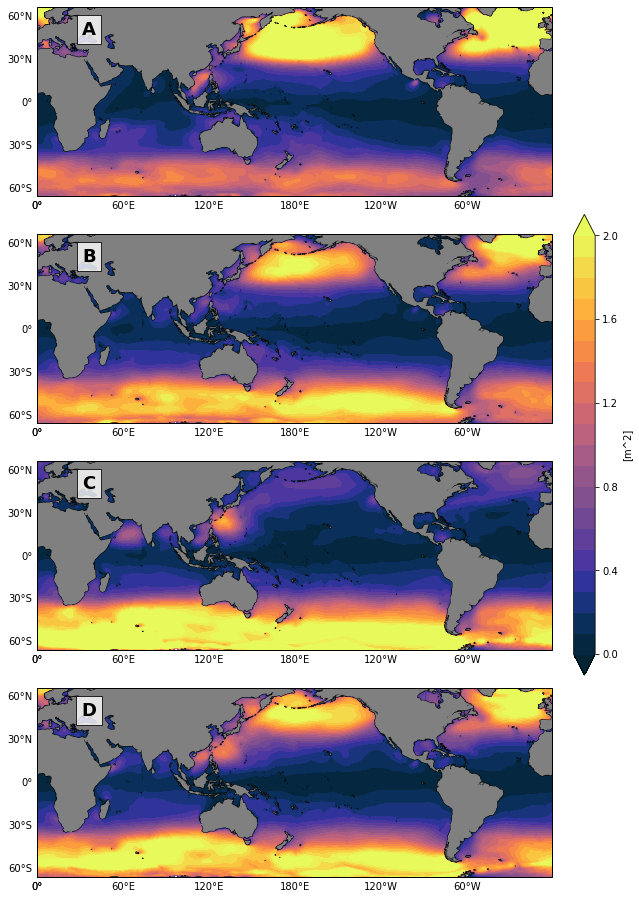

In [13]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 1, figsize=(10,16),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 2.1, 0.1)
cs1 = ax1.contourf(lon_c, lat_c, swh_var_s[0,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.90, .3, 0.03, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='[m^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 2.1, 0.1)
cs2 = ax2.contourf(lon_c, lat_c, swh_var_s[1,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax2 = plt.axes([.92, .71, 0.01, 0.16])
#cart.set_cbar(cs2, cax2, fig, cbar_label ='[m^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 2.1, 0.1)
cs3 = ax3.contourf(lon_c, lat_c, swh_var_s[2,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 2.1, 0.1)
cs4 = ax4.contourf(lon_c, lat_c, swh_var_s[3,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)


#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0.2)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/stat_moments/WW3/CFSR/WW3_seasonal_var_swh', bbox_inches = 'tight', dpi=300)


###### Skewness

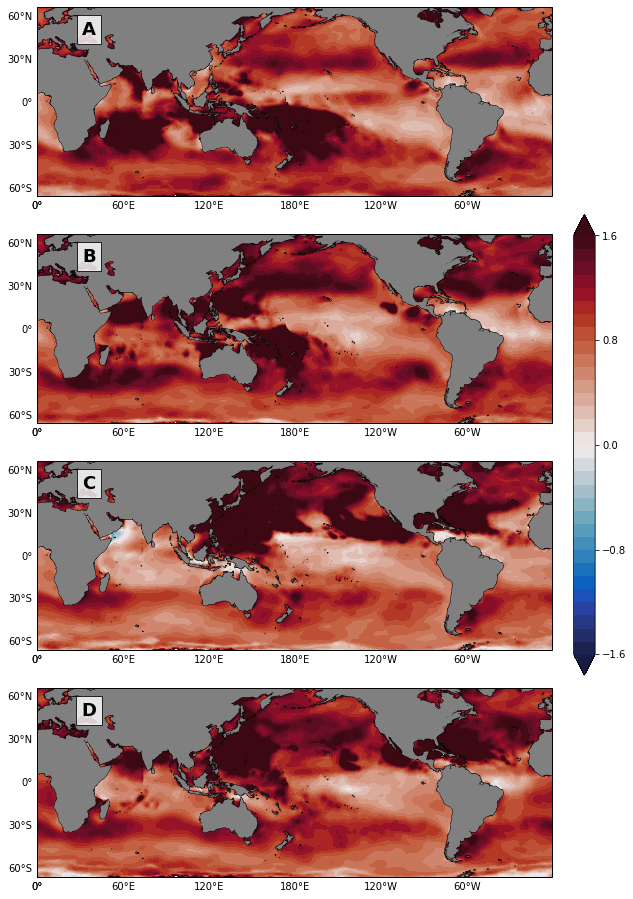

In [24]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 1, figsize=(10,16),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.6, 1.7, 0.1)
cs1 = ax1.contourf(lon_c, lat_c, swh_skew_s[0,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.90, .3, 0.03, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.6, 1.7, 0.1)
cs2 = ax2.contourf(lon_c, lat_c, swh_skew_s[1,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax2 = plt.axes([.92, .71, 0.01, 0.16])
#cart.set_cbar(cs2, cax2, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.6, 1.7, 0.1)
cs3 = ax3.contourf(lon_c, lat_c, swh_skew_s[2,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.6, 1.7, 0.1)
cs4 = ax4.contourf(lon_c, lat_c, swh_skew_s[3,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)


#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0.2)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/stat_moments/WW3/CFSR/WW3_seasonal_skew_swh', bbox_inches = 'tight', dpi=300)


###### Kurtosis

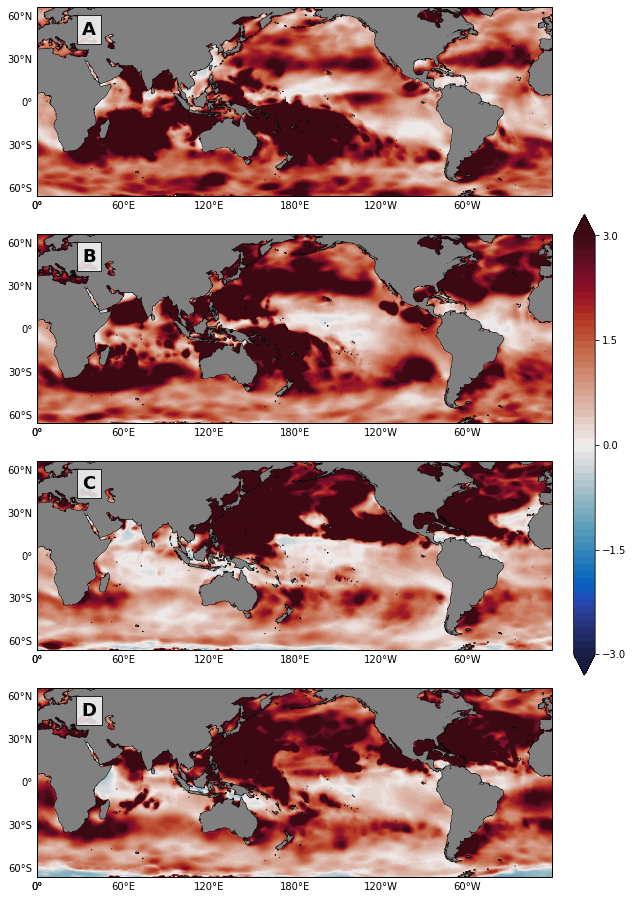

In [25]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 1, figsize=(10,16),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-3, 3.1, 0.1)
cs1 = ax1.contourf(lon_c, lat_c, swh_kurt_s[0,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.90, .3, 0.03, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-3, 3.1, 0.1)
cs2 = ax2.contourf(lon_c, lat_c, swh_kurt_s[1,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax2 = plt.axes([.92, .71, 0.01, 0.16])
#cart.set_cbar(cs2, cax2, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-3, 3.1, 0.1)
cs3 = ax3.contourf(lon_c, lat_c, swh_kurt_s[2,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-3, 3.1, 0.1)
cs4 = ax4.contourf(lon_c, lat_c, swh_kurt_s[3,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)


#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0.2)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/stat_moments/WW3/CFSR/WW3_seasonal_kurt_swh', bbox_inches = 'tight', dpi=300)

#### WSP

###### Mean

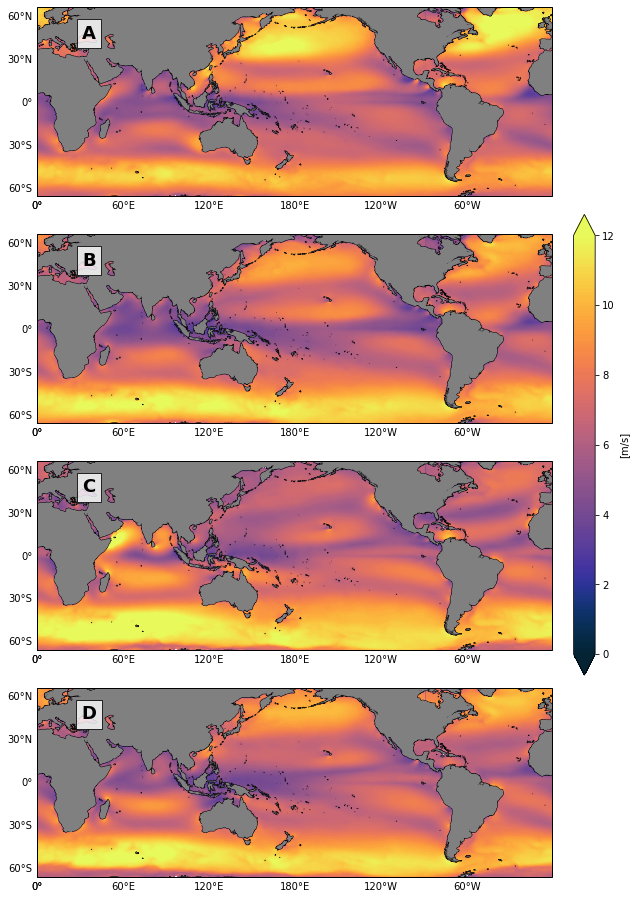

In [21]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 1, figsize=(10,16),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 12.1, 0.1)
cs1 = ax1.contourf(lon_c, lat_c, wsp_mean_s[0,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.90, .3, 0.03, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='[m/s]', nbins = 6, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.86, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 12.1, 0.1)
cs2 = ax2.contourf(lon_c, lat_c, wsp_mean_s[1,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax2 = plt.axes([.92, .71, 0.01, 0.16])
#cart.set_cbar(cs2, cax2, fig, cbar_label ='[m^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.86, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 12.1, 0.1)
cs3 = ax3.contourf(lon_c, lat_c, wsp_mean_s[2,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.86, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 12.1, 0.1)
cs4 = ax4.contourf(lon_c, lat_c, wsp_mean_s[3,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.86, subplot_label = 'D', fs_shade = 28, fs_main = 18)


#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0.2)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/stat_moments/WW3/CFSR/WW3_seasonal_mean_wsp', bbox_inches = 'tight', dpi=300)

###### Variance

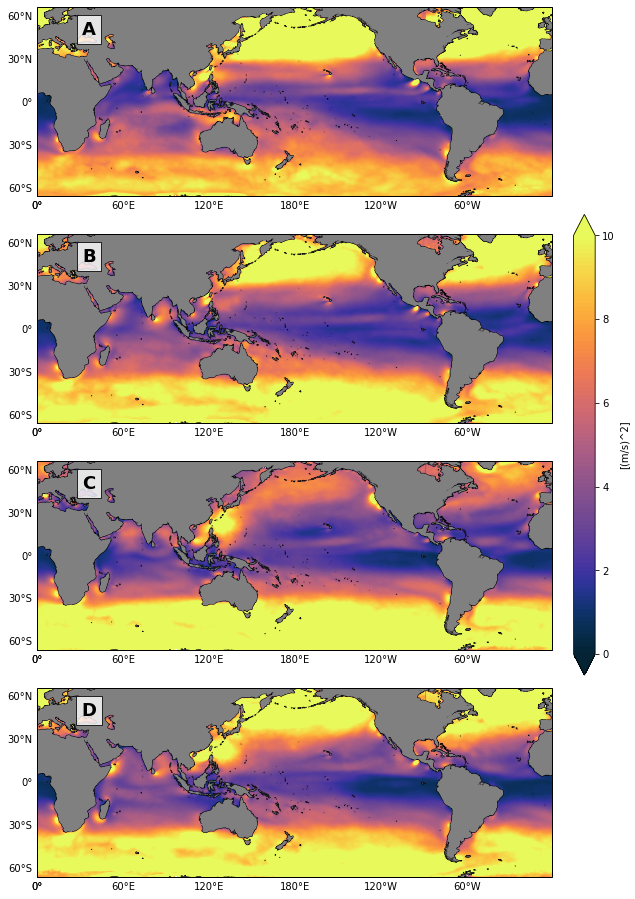

In [17]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 1, figsize=(10,16),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 10.1, 0.1)
cs1 = ax1.contourf(lon_c, lat_c, wsp_var_s[0,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.90, .3, 0.03, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='[(m/s)^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 10.1, 0.1)
cs2 = ax2.contourf(lon_c, lat_c, wsp_var_s[1,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax2 = plt.axes([.92, .71, 0.01, 0.16])
#cart.set_cbar(cs2, cax2, fig, cbar_label ='[m^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0, 10.1, 0.1)
cs3 = ax3.contourf(lon_c, lat_c, wsp_var_s[2,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(0.0, 10.1, 0.1)
cs4 = ax4.contourf(lon_c, lat_c, wsp_var_s[3,:,:], levels=levels, cmap=cmo.thermal,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m^2]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)


#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0.2)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/stat_moments/WW3/CFSR/WW3_seasonal_var_wsp', bbox_inches = 'tight', dpi=300)


###### Skewness

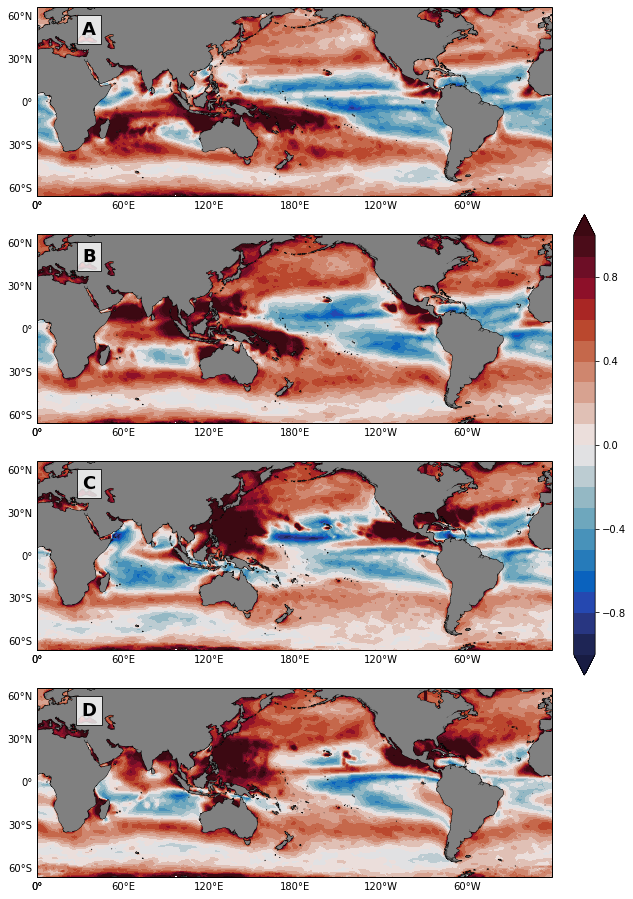

In [22]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 1, figsize=(10,16),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1, 1.1, 0.1)
cs1 = ax1.contourf(lon_c, lat_c, wsp_skew_s[0,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.90, .3, 0.03, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1, 1.1, 0.1)
cs2 = ax2.contourf(lon_c, lat_c, wsp_skew_s[1,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax2 = plt.axes([.92, .71, 0.01, 0.16])
#cart.set_cbar(cs2, cax2, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1, 1.1, 0.1)
cs3 = ax3.contourf(lon_c, lat_c, wsp_skew_s[2,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1, 1.1, 0.1)
cs4 = ax4.contourf(lon_c, lat_c, wsp_skew_s[3,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)


#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0.2)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/stat_moments/WW3/CFSR/WW3_seasonal_skew_wsp', bbox_inches = 'tight', dpi=300)


###### Kurtosis

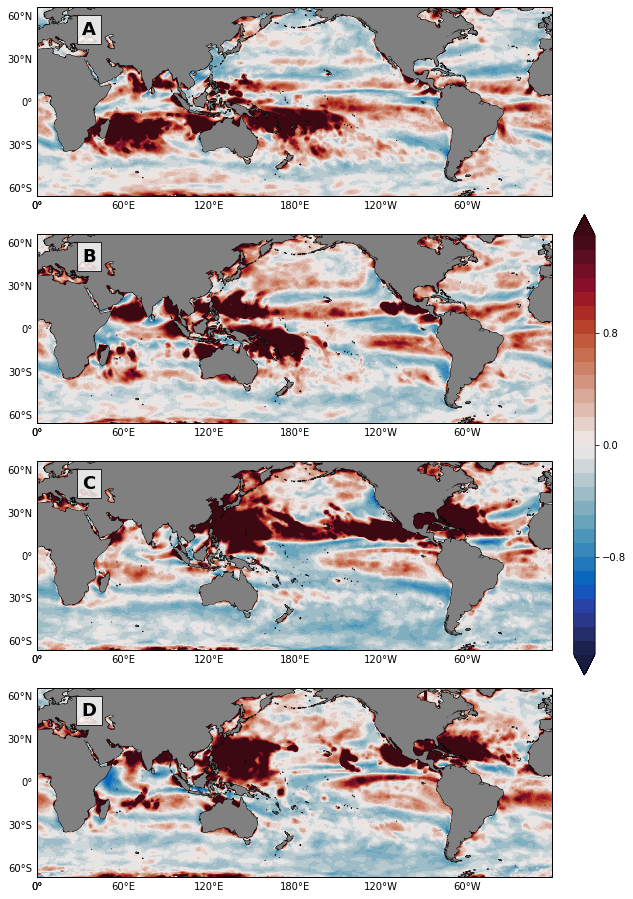

In [23]:
projection = ccrs.PlateCarree(central_longitude=180.0)
resolution = '50m'

fig, axes = plt.subplots(4, 1, figsize=(10,16),
                        subplot_kw={'projection': projection})
ax1, ax2, ax3, ax4 = axes.flatten()

############## Subplot 1  #################
cart.set_subplots(ax1, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.5, 1.6, 0.1)
cs1 = ax1.contourf(lon_c, lat_c, wsp_kurt_s[0,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax1,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#left, bottom, width, height
cax1 = plt.axes([.90, .3, 0.03, 0.4])
cart.set_cbar(cs1, cax1, fig, cbar_label ='', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax1, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax1, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'A', fs_shade = 28, fs_main = 18)

############## Subplot 2  #################
cart.set_subplots(ax2, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.5, 1.6, 0.1)
cs2 = ax2.contourf(lon_c, lat_c, wsp_kurt_s[1,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax2,xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax2 = plt.axes([.92, .71, 0.01, 0.16])
#cart.set_cbar(cs2, cax2, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax2, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax2, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'B', fs_shade = 28, fs_main = 18)

############## Subplot 3  #################
cart.set_subplots(ax3, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.5, 1.6, 0.1)
cs3 = ax3.contourf(lon_c, lat_c, wsp_kurt_s[2,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax3, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax3 = plt.axes([.47, .42, 0.01, 0.16])
#cart.set_cbar(cs3, cax3, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax3, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 15)
cart.subplot_label(ax3, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'C', fs_shade = 28, fs_main = 18)

############## Subplot 4  #################
cart.set_subplots(ax4, projection, resolution, lon_min=-180, lon_max=179, lat_min=-66, lat_max=66)
levels = np.arange(-1.5, 1.6, 0.1)
cs4 = ax4.contourf(lon_c, lat_c, wsp_kurt_s[3,:,:], levels=levels, cmap=cmo.balance,
                  extend='both', transform=ccrs.PlateCarree(central_longitude=0.0))
cart.set_grid_labels(ax4, xticks = [0, 60, 120, 180, -120, -60, -0], yticks = [-60, -30, 0, 30, 60], 
                     xgrid = False, ygrid = False)
#cax4 = plt.axes([.92, .52, 0.01, 0.16])
#cart.set_cbar(cs4, cax4, fig, cbar_label ='[m]', nbins = 5, fontsize = 10)
#cart.set_axes_label(ax4, xdist_lat = -0.1, ydist_lat = 0.50, xdist_lon = 0.5, ydist_lon = -0.25, fontsize = 10)
cart.subplot_label(ax4, xdist_label = 0.1, ydist_label = 0.88, subplot_label = 'D', fs_shade = 28, fs_main = 18)


#adjust spacing for the entire figure (not the subplot)
plt.subplots_adjust(wspace = 0.21, hspace = 0.2)

#save figure 
plt.savefig(fname = '/zdata/downloads/colosi_data_bk/surfacewaves_python_figs/stat_moments/WW3/CFSR/WW3_seasonal_kurt_wsp', bbox_inches = 'tight', dpi=300)

Compute statistical moments of the data monthly in order to make sure I am obtaining a realistic mean and variance data globally in order to confirm that the monthly mean and variance in the regional climatologies is correct

In [20]:
swh_stats_m = stat_moments_temporal(data=swh_c, date_time=time_c, task='monthly')
wsp_stats_m = stat_moments_temporal(data=wsp_c, date_time=time_c, task='monthly')

KeyboardInterrupt: 

Assign key variables from dictionary as variables and convert variables to numpy arrays

In [ ]:
#For SWH:
swh_mean_m = np.ma.array(swh_stats_m['mean'])
swh_var_m = np.ma.array(swh_stats_m['var'])
#swh_skew_s = np.ma.array(swh_stats_s['skew'])
#swh_kurt_s = np.ma.array(swh_stats_s['kurt'])

#For WSP:
wsp_mean_m = np.ma.array(wsp_stats_m['mean'])
wsp_var_m = np.ma.array(wsp_stats_m['var'])
#wsp_skew_s = np.ma.array(wsp_stats_s['skew'])
#wsp_kurt_s = np.ma.array(wsp_stats_s['kurt'])

Plot the month progression for each statistical moment without using cartopy

In [ ]:
#initialize figure: 
fig1 = plt.figure(figsize=(16, 12))
fig1.suptitle('SWH Global Characteristics of Annual and Semi-annual Least Square Fit ', fontsize=20)

#June Subplot
plt.subplot(4,3,1)
plt.pcolor(lon,lat,swh_mean_m[11,:,:], vmin=0, vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(-np.pi, np.pi + 0.1, 0.1)
#plt.contourf(lon,lat,swh_phase2_m,levels=levels,cmap=cm.hsv,extend='min')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Dec', fontsize=16)
plt.grid()

#RMS subplot: 
plt.subplot(432)

#pcolor plot: 
plt.pcolor(lon,lat,swh_mean_m[0,:,:],vmin=0,vmax=4.5, cmap=cmo.thermal)

#contourf plot:
#set levels of contours
#levels = np.arange(0.0, 1.1, 0.1)
#plt.contourf(lon,lat,swh_rms_m,levels=levels,cmap=cmo.thermal,extend='min')
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Jan', fontsize=16)
plt.grid()

#Coefficient of Determination subplot: 
plt.subplot(433)
plt.pcolor(lon,lat,swh_mean_m[1,:,:],vmin=0,vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(0.0, 1.1, 0.1)
#plt.contourf(lon,lat,swh_mean_m[1,:,:],levels=levels,cmap=cmo.thermal,extend='min')
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[%]', fontsize=14)
#label figure 
plt.title('Feb', fontsize=16)
plt.grid()

#Annual Amplitude subplot: 
plt.subplot(434)
plt.pcolor(lon,lat,swh_mean_m[2,:,:],vmin=0,vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(0.0, 1.1, 0.1)
#plt.contourf(lon,lat,swh_amp1_m,levels=levels,cmap=cmo.thermal,extend='min')
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Mar', fontsize=16)
plt.grid()

#Semi-annual Amplitude subplot: 
plt.subplot(435)
plt.pcolor(lon,lat,swh_mean_m[3,:,:],vmin=0,vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(0.0, 0.6, 0.1)
#plt.contourf(lon,lat,swh_amp2_m,levels=levels,cmap=cmo.thermal,extend='min')
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Apr', fontsize=16)
plt.grid()

#Annual Phase subplot: 
plt.subplot(436)
plt.pcolor(lon,lat,swh_mean_m[4,:,:], vmin=0, vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(-np.pi, np.pi + 0.1, 0.1)
#plt.contourf(lon,lat,swh_phase1_m,levels=levels,cmap=cm.hsv,extend='min')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('May', fontsize=16)
plt.grid()

#June Subplot
plt.subplot(437)
plt.pcolor(lon,lat,swh_mean_m[5,:,:], vmin=0, vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(-np.pi, np.pi + 0.1, 0.1)
#plt.contourf(lon,lat,swh_phase2_m,levels=levels,cmap=cm.hsv,extend='min')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Jun', fontsize=16)
plt.grid()

#June Subplot
plt.subplot(438)
plt.pcolor(lon,lat,swh_mean_m[6,:,:], vmin=0, vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(-np.pi, np.pi + 0.1, 0.1)
#plt.contourf(lon,lat,swh_phase2_m,levels=levels,cmap=cm.hsv,extend='min')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Jul', fontsize=16)
plt.grid()

#July Subplot
plt.subplot(439)
plt.pcolor(lon,lat,swh_mean_m[7,:,:], vmin=0, vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(-np.pi, np.pi + 0.1, 0.1)
#plt.contourf(lon,lat,swh_phase2_m,levels=levels,cmap=cm.hsv,extend='min')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Aug', fontsize=16)
plt.grid()

#June Subplot
plt.subplot(4,3,10)
plt.pcolor(lon,lat,swh_mean_m[8,:,:], vmin=0, vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(-np.pi, np.pi + 0.1, 0.1)
#plt.contourf(lon,lat,swh_phase2_m,levels=levels,cmap=cm.hsv,extend='min')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Sep', fontsize=16)
plt.grid()

#June Subplot
plt.subplot(4,3,11)
plt.pcolor(lon,lat,swh_mean_m[9,:,:], vmin=0, vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(-np.pi, np.pi + 0.1, 0.1)
#plt.contourf(lon,lat,swh_phase2_m,levels=levels,cmap=cm.hsv,extend='min')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Oct', fontsize=16)
plt.grid()

#June Subplot
plt.subplot(4,3,12)
plt.pcolor(lon,lat,swh_mean_m[10,:,:], vmin=0, vmax=4.5, cmap=cmo.thermal)
#levels = np.arange(-np.pi, np.pi + 0.1, 0.1)
#plt.contourf(lon,lat,swh_phase2_m,levels=levels,cmap=cm.hsv,extend='min')
plt.xlabel('longitude', fontsize=14)
plt.ylabel('latitude', fontsize=14)
#set colorbar
cbar = plt.colorbar()
#label colorbar and set font
cbar.set_label('[m]', fontsize=14)
#label figure 
plt.title('Nov', fontsize=16)
plt.grid()


In [ ]:
%reset